# Setting

In [1]:
from pf_utils import DataManager, FinancialRatios, BacktestManager, MomentumPortfolio
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'
path_tran = 'transaction'

*data for backtesting*

In [3]:
file_bt_price = 'kospi200_bt_prices_040102_241023.csv'
file_bt_ratio = 'kospi200_bt_ratios_040131_240930.csv'

# Data

## Price

In [74]:
file = 'kospi200_prices.csv'

*Uncomment for backtesting*

In [75]:
#file = file_bt_price

In [76]:
k200 = DataManager(
    universe = 'kospi200',
    file = file,
    path = path_data
)
k200.upload()

201 assets from 2021-01-04 to 2024-10-25 uploaded.
df_prices updated


In [77]:
df_k200 = k200.df_prices.ffill()
assetnames_k200 = k200.get_names()

## Ratios

In [78]:
WidgetUniverse

In [79]:
is_backtest = True if k200.file_historical == file_bt_price else False

In [80]:
file = 'kospi200_ratios.csv' if not is_backtest else file_bt_ratio
fr = FinancialRatios(file, path_data)

Financial ratios of 201 stocks from 2023-01-02 to 2024-10-25 loaded


In [81]:
start = '2023-01-01'
tickers = df_k200.columns.to_list()
kw = dict(
    freq = 'd',
    close_today = WidgetUniverse.values(1) 
)
fr.download(tickers, start, **kw) if not is_backtest and WidgetUniverse.values(0) else None

In [82]:
#fr.calc_rank(metrics='PER', date='start', topn=None)
fr.calc_rank(metrics='PER', topn=None)

Ranking score of PER on 2024-10-25


ticker
010060    0.000000
003030    0.006211
016380    0.012422
009970    0.018634
047040    0.024845
            ...   
009420    0.975155
329180    0.981366
377300    0.987578
450080    0.993789
004800    1.000000
Name: PER, Length: 162, dtype: float64

In [83]:
#fr.calc_historical()
fr.calc_historical(['PER', 'PBR'])

Historical of PER+PBR ranking score created


ticker  date      
005930  2023-01-02    1.115655
        2023-01-03    1.120757
        2023-01-04    1.146513
        2023-01-05    1.162310
        2023-01-06    1.167412
                        ...   
105630  2024-10-21    0.747569
        2024-10-22    0.731519
        2024-10-23    0.726519
        2024-10-24    0.755069
        2024-10-25    0.737044
Name: PER, Length: 88315, dtype: float64

In [84]:
#fr.get_stats(stats_daily=False)
fr.get_stats()

Returning stats of daily averages


,BPS,PER,PBR,EPS,DIV,DPS
start,2023-01-02,2023-01-02,2023-01-02,2023-01-02,2023-01-02,2023-01-02
end,2024-10-25,2024-10-25,2024-10-25,2024-10-25,2024-10-25,2024-10-25
mean,105856.3,69.9,2.3,8746.6,2.4,1815.7
std,3555.0,41.1,0.3,1367.9,0.1,122.3


## Reshape
Interpolate & Reshape for backtesting

In [85]:
df_p = fr.util_reshape(df_k200)

fratios_dict = dict()
for r in ['PER', 'PBR']:
    df = fr.interpolate(df_p, r)
    fratios_dict[r] = fr.util_reshape(df, stack=False)

# Backtest

## Example

In [20]:
fratio = 'PER'
df_ratio = fratios_dict[fratio]

In [21]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

426 assets from 2004-01-02 to 2024-10-23 uploaded.
running self.util_check_days_in_year to check days in a year


In [22]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [23]:
#bm.buy_n_hold(name='PER', weigh='equally')

In [24]:
kwargs_build = dict(
    name=fratio, select='f-ratio', weigh='Equally', 
    n_assets=10, freq='Y', lookback=0,
    df_ratio=df_ratio, ratio_descending=False
)
bm.build(**kwargs_build)

Backtesting 2 strategies: KODEX200, PER


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.01s/it]


Returning stats


,PER,KODEX200
start,2004-01-01,2004-01-01
end,2024-10-23,2024-10-23
total_return,6.426956,3.663985
cagr,0.101146,0.076802
calmar,0.179145,0.145784
max_drawdown,-0.564605,-0.526819
avg_drawdown,-0.05683,-0.034751
avg_drawdown_days,101.333333,63.575221
daily_vol,0.184887,0.204754
daily_sharpe,0.622523,0.471124


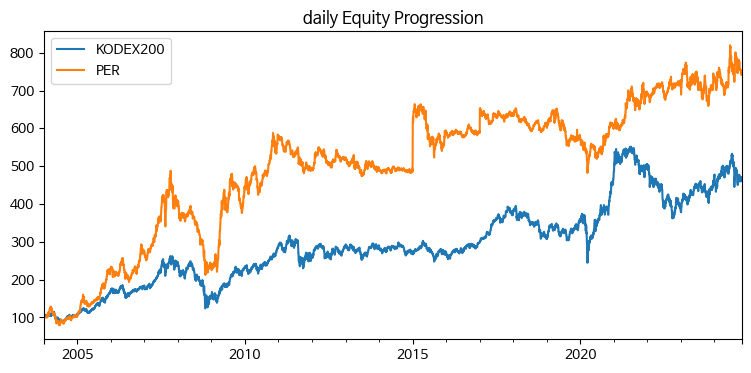

In [25]:
bm.run(figsize=(9,4), stats_sort_by='cagr')

In [26]:
bm.portfolios

0) KODEX200
1) PER

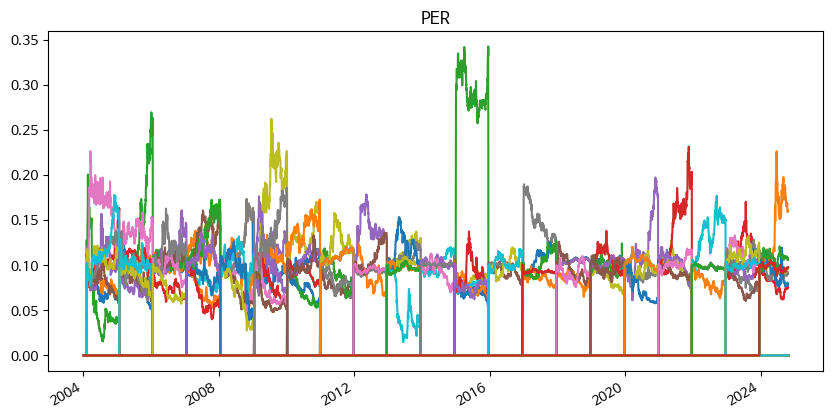

In [27]:
bm.plot_security_weights(1, legend=False)

## Parameter study

In [20]:
len(df_k200)

5142

In [21]:
n_val = 400
lookback = 100
df = df_k200
df_train = df.iloc[:-n_val]
df_val = df.iloc[-n_val-lookback:]

In [22]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)

### Cross-validate

In [23]:
from itertools import product

p_args = dict(
    #p_fr = ['PER', 'PBR', 'PER+PBR'],
    p_fr = ['PER'],
    p_ast = [5, 10, 20, 30],
    p_freq = [130, 250, 500],
    p_lb = [0, 5, 10, 20, 30, 60] # days
)
p_comb = list(product(*p_args.values()))
params = [{'name':'{}:a{}/f{}/lb{}'.format(*x),
           'df_ratio':x[0], 'n_assets':x[1], 'freq':x[2], 'lookback':x[3]} 
          for x in p_comb]
params[0]

{'name': 'PER:a5/f130/lb0',
 'df_ratio': 'PER',
 'n_assets': 5,
 'freq': 130,
 'lookback': 0}

In [24]:
convert_args = lambda p: [{**x, 'df_ratio': fratios_dict[x['df_ratio']], 
                           'lookback':f'{x['lookback']} days'} for x in p]

In [25]:
bm = BacktestManager(df_train, **kwargs_bm)

426 assets from 2004-01-02 to 2023-03-03 uploaded.
running self.util_check_days_in_year to check days in a year


In [26]:
kwa_list = convert_args(params)

kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_descending=False, build_cv=True
)
bm.build_batch(*kwa_list, **kwargs_build)

72 jobs prepared for cross-validation


In [28]:
kw_batch = dict(size_batch=9, path_batch=path_data)
bm.cross_validate(n_sample=20, **kw_batch)

Cross-validating 72 strategies: PER:a5/f130/lb0, PER:a5/f130/lb5, ... , PER:a30/f500/lb60


100%|███████████████████████████████████████████████████████████████| 19/19 [01:42<00:00,  5.41s/it]


115.1 mins elapsed, 0.0 secs paused (0.0%)


### Visualize

In [29]:
file = 'param_per_k2hl.csv'

*Save param study*

In [30]:
f = dict(file=file, path=path_data)
df_cv = bm.get_cat_data(params, **f)

data/param_per_k2hl.csv saved
72 param sets with 19 iterations per set


*Load param study*

In [31]:
bm = BacktestManager
df_cv = bm.catplot(file, path=path_data)

Returning data/param_per_k2hl.csv
72 param sets with 19 iterations per set


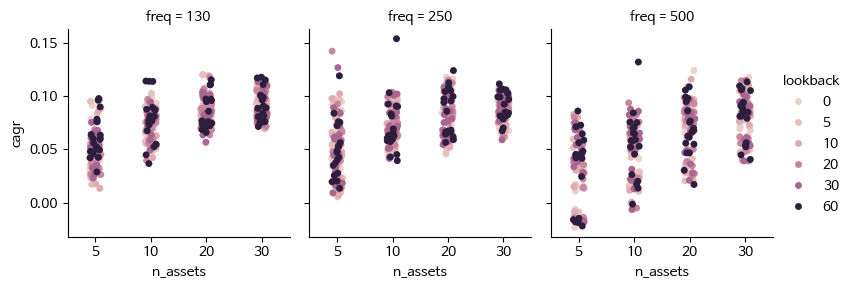

In [37]:
#kw = {'x':'lookback', 'row':'freq', 'col':'n_assets'}
kw = {'hue':'lookback', 'col':'freq', 'x':'n_assets'}

_ = bm.catplot(data=df_cv, y='cagr', height=3, aspect=.9, **kw)

### Validation

In [53]:
bm = BacktestManager(df_val, **kwargs_bm)

426 assets from 2022-10-11 to 2024-10-23 uploaded.
running self.util_check_days_in_year to check days in a year


In [54]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [55]:
#p_comb = [[30, 130], [20, 130], [10, 130], [5, 130]]
p_comb = [[30, 130], [30, 250], [5, 130], [5, 250]]
kwa_list = [{'name':'PER:a{}/f{}'.format(*x), 'n_assets':x[0], 'freq':x[1]} for x in p_comb]

Backtesting 5 strategies: KODEX200, PER:a30/f130, PER:a30/f250, PER:a5/f130, PER:a5/f250


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]

Returning stats


,PER:a5/f250,PER:a5/f130,KODEX200,PER:a30/f250,PER:a30/f130
start,2022-10-10,2022-10-10,2022-10-10,2022-10-10,2022-10-10
end,2024-10-23,2024-10-23,2024-10-23,2024-10-23,2024-10-23
total_return,0.396334,0.314762,0.274088,0.080747,0.073248
cagr,0.178092,0.143787,0.126277,0.038858,0.035313
calmar,0.797843,0.865416,0.766397,0.343622,0.280314
max_drawdown,-0.223217,-0.166148,-0.164768,-0.113082,-0.125976
avg_drawdown,-0.048707,-0.034558,-0.030914,-0.025242,-0.026532
avg_drawdown_days,29.652174,36.473684,22.586207,70.6,70.6
daily_vol,0.264456,0.193614,0.182829,0.108617,0.105579
daily_sharpe,0.767637,0.80882,0.759795,0.414565,0.390136


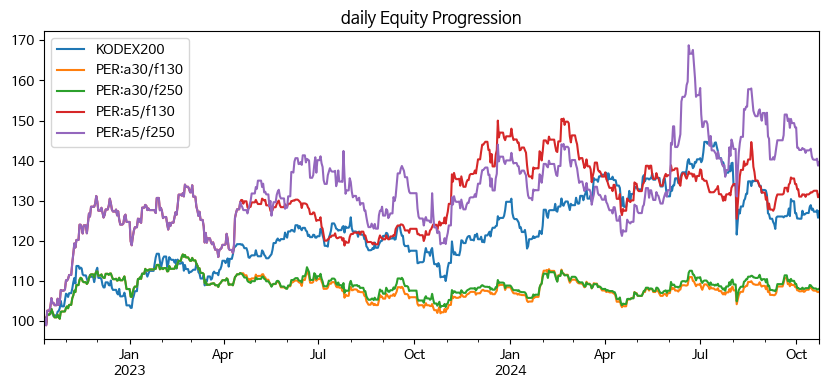

In [56]:
kwargs_build = dict(
    select='f-ratio', weigh='Equally', 
    ratio_descending=False, build_cv=False,
    df_ratio=fratios_dict['PER']
)
bm.build_batch(*kwa_list, **kwargs_build)

bm.run(stats_sort_by='cagr', figsize=(10,4))

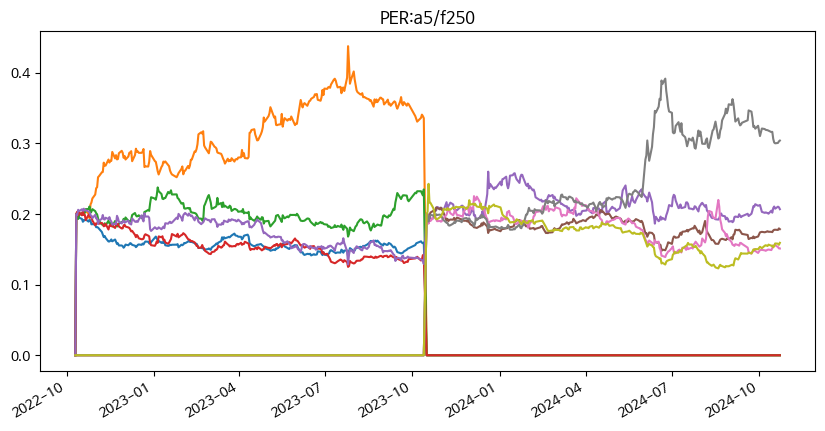

In [59]:
bm.plot_security_weights(4, legend=False)

# Transaction

In [86]:
df_ratio = fratios_dict['PER']

In [87]:
kwargs = dict(
    name='PER',
    #file='pf_k200_per.csv',
    file='test_per.csv',
    path=path_tran,
    days_in_year=246,
    asset_names=assetnames_k200,
    lookback='5 days', # days
    df_additional=df_ratio,
    method_weigh='equally',
)
kwargs.update(MomentumPortfolio.check_init_args('per'))

pf_per = MomentumPortfolio(df_k200, **kwargs)

201 assets from 2021-01-04 to 2024-10-25 uploaded.
running self.util_check_days_in_year to check days in a year
REMINDER: make sure this is 1st transaction as no records provided


In [88]:
pf_per.view_record()

ERROR: No transaction record


In [89]:
pf_per.valuate()

ERROR: No transaction record


In [90]:
# set kwargs of transaction_pipeline
WidgetTransaction

In [93]:
kwargs_trs = dict(
    n_assets = 5,
    date = WidgetTransaction.values(0),
    capital = WidgetTransaction.values(1),
    save = WidgetTransaction.values(2)
)

_ = pf_per.transaction_pipeline(**kwargs_trs)
pf_per.view_record()

Liquidation set to None
5 assets selected by Financial Ratio from 2024-06-26 to 2024-07-01
Weights of assets determined by Equal weights.
Mean absolute error of weights: 2 %
Portfolio value 9,555,380, Profit -2.4% on 2024-10-25
Set save=True to save transaction record


name   price  transaction  net weight weight*
date       asset                                                   
2024-07-01 010060   OCI홀딩스   87800           22   22  0.200  0.1973
           009970  영원무역홀딩스   81500           24   24  0.200  0.1998
           003030   세아제강지주  192300           10   10  0.200  0.1964
           016380     KG스틸    6460          309  309  0.200  0.2039
           111770     영원무역   34800           57   57  0.200  0.2026

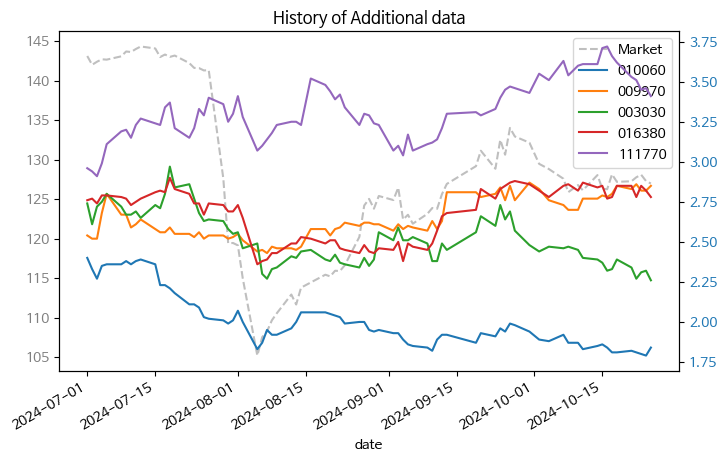

In [94]:
_ = pf_per.check_additional(plot=True)